In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import glob
import os

# Extract depth20 ZIP
depth_zip = "depth20_1000ms-20250627T144523Z-1-001.zip"
depth_folder = "depth20_extracted"
with zipfile.ZipFile(depth_zip, 'r') as zip_ref:
    zip_ref.extractall(depth_folder)

# Extract aggTrade ZIP
agg_zip = "aggTrade-20250627T143353Z-1-001.zip"
agg_folder = "aggTrade_extracted"
with zipfile.ZipFile(agg_zip, 'r') as zip_ref:
    zip_ref.extractall(agg_folder)

# Load all TXT files from both datasets
depth_txt_files = glob.glob(os.path.join(depth_folder, "**", "*.txt"), recursive=True)
agg_txt_files = glob.glob(os.path.join(agg_folder, "**", "*.txt"), recursive=True)

# Combine into single DataFrames
depth_df = pd.concat([pd.read_csv(f) for f in depth_txt_files], ignore_index=True)
agg_df = pd.concat([pd.read_csv(f) for f in agg_txt_files], ignore_index=True)

# Preview data
print("📄 Depth Data (First 5 Rows):")
print(depth_df.head())

print("\n📄 AggTrade Data (First 5 Rows):")
print(agg_df.head())


📄 Depth Data (First 5 Rows):
                                      Time  BidPriceL20  BidQtyL20  \
0  2025-03-14 00:00:02.292522546 +0530 IST       579.20      0.621   
1  2025-03-14 00:00:03.292828523 +0530 IST       579.08      2.612   
2  2025-03-14 00:00:04.292889586 +0530 IST       579.14      1.948   
3  2025-03-14 00:00:05.292551566 +0530 IST       579.07      0.013   
4  2025-03-14 00:00:06.292725093 +0530 IST       579.11      9.143   

   BidPriceL19  BidQtyL19  BidPriceL18  BidQtyL18  BidPriceL17  BidQtyL17  \
0       579.24      0.015       579.25      0.009       579.26      0.013   
1       579.09      8.606       579.10      3.453       579.11      3.825   
2       579.15      3.957       579.18      1.681       579.19      3.465   
3       579.08      0.013       579.09      8.606       579.10      3.453   
4       579.12      6.361       579.13      5.837       579.14      2.816   

   BidPriceL16  ...  AskPriceL16  AskQtyL16  AskPriceL17  AskQtyL17  \
0       579.27  

In [17]:
# ✅ Feature Engineering with correct column names

# Spread = Ask Price (Level 1) - Bid Price (Level 1)
depth_df['spread'] = depth_df['AskPriceL1'] - depth_df['BidPriceL1']

# Mid-Price = (Ask + Bid) / 2
depth_df['mid_price'] = (depth_df['AskPriceL1'] + depth_df['BidPriceL1']) / 2

# Order Book Imbalance (Level 1)
depth_df['obi_level1'] = (
    depth_df['BidQtyL1'] - depth_df['AskQtyL1']
) / (depth_df['BidQtyL1'] + depth_df['AskQtyL1'])

# Full Depth Order Book Imbalance (20 levels)
bid_qty_cols = [f'BidQtyL{i}' for i in range(1, 21)]
ask_qty_cols = [f'AskQtyL{i}' for i in range(1, 21)]

depth_df['obi_full'] = (
    depth_df[bid_qty_cols].sum(axis=1) - depth_df[ask_qty_cols].sum(axis=1)
) / (depth_df[bid_qty_cols].sum(axis=1) + depth_df[ask_qty_cols].sum(axis=1))

# Rolling Volatility (of mid-price)
depth_df['rolling_volatility'] = depth_df['mid_price'].rolling(window=20).std()



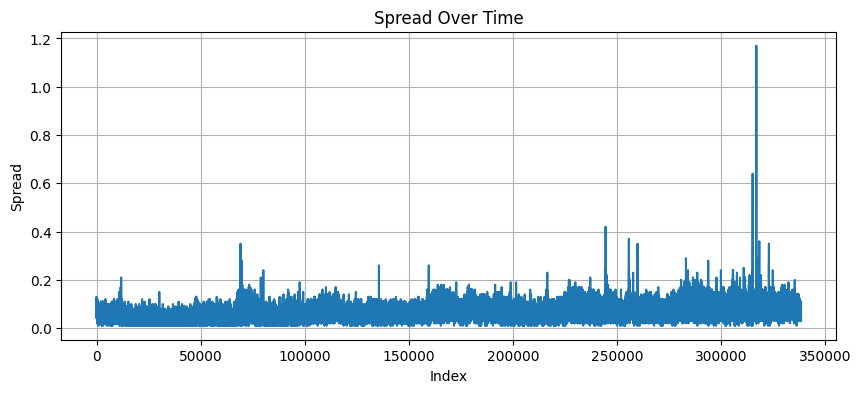

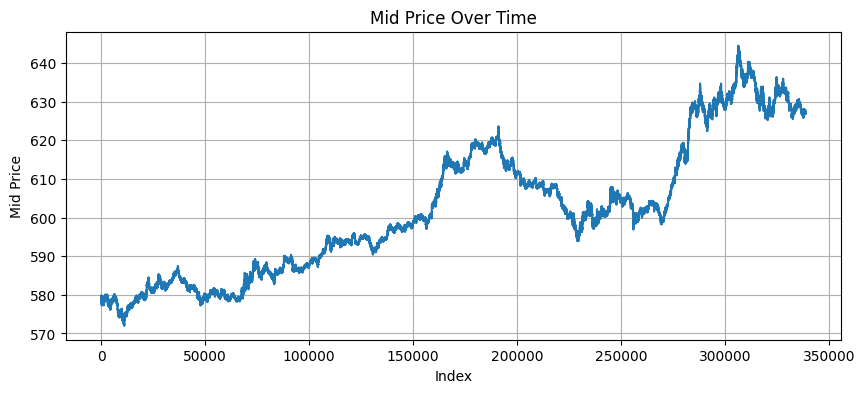

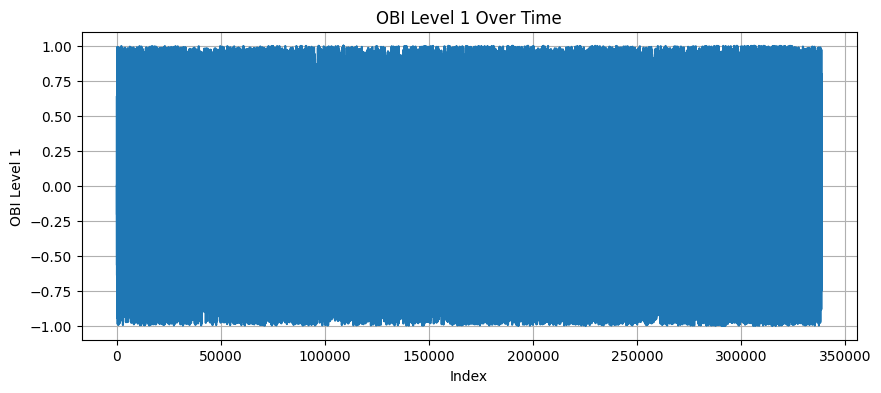

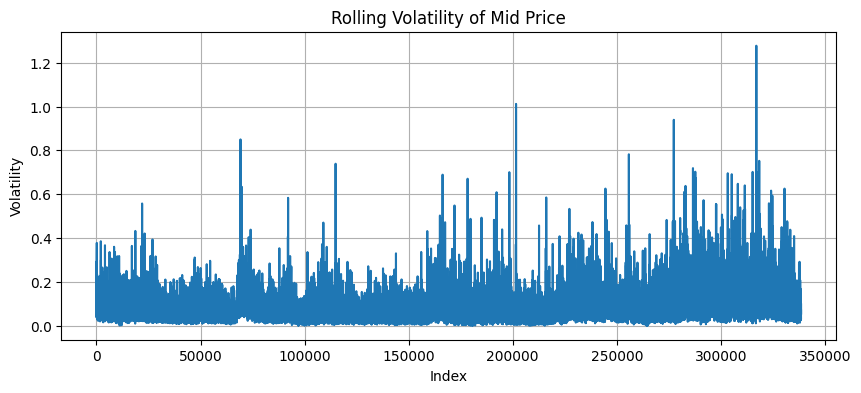

✅ Exported final feature dataset as 'features_week2.csv'
📦 Final Feature Preview:
        spread  mid_price  obi_level1  obi_full  rolling_volatility
338514    0.08    627.660   -0.026627 -0.030165            0.054832
338515    0.07    627.715   -0.013493 -0.048514            0.063376
338516    0.07    627.715   -0.013493 -0.055437            0.065797
338517    0.06    627.720    0.307377 -0.126455            0.066745
338518    0.06    627.760    0.304703 -0.470126            0.069309


In [18]:
# Plot: Spread
plt.figure(figsize=(10, 4))
plt.plot(depth_df['spread'])
plt.title("Spread Over Time")
plt.xlabel("Index")
plt.ylabel("Spread")
plt.grid(True)
plt.show()

# Plot: Mid-Price
plt.figure(figsize=(10, 4))
plt.plot(depth_df['mid_price'])
plt.title("Mid Price Over Time")
plt.xlabel("Index")
plt.ylabel("Mid Price")
plt.grid(True)
plt.show()

# Plot: Order Book Imbalance (Level 1)
plt.figure(figsize=(10, 4))
plt.plot(depth_df['obi_level1'])
plt.title("OBI Level 1 Over Time")
plt.xlabel("Index")
plt.ylabel("OBI Level 1")
plt.grid(True)
plt.show()

# Plot: Rolling Volatility
plt.figure(figsize=(10, 4))
plt.plot(depth_df['rolling_volatility'])
plt.title("Rolling Volatility of Mid Price")
plt.xlabel("Index")
plt.ylabel("Volatility")
plt.grid(True)
plt.show()

# Export final features
features = ['spread', 'mid_price', 'obi_level1', 'obi_full', 'rolling_volatility']
final_df = depth_df[features]
final_df.to_csv("features_week2.csv", index=False)

print("✅ Exported final feature dataset as 'features_week2.csv'")
print("📦 Final Feature Preview:")
print(final_df.tail())
